In [1]:
using StatsBase, Plotly, DataFrames, PyPlot

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-8348430928657200617\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-9215834072004415783\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-8348430928657200617\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
struct Bairro
    nResidencias::Integer # numero de residencias naquele bairro
    nPessoas::Integer # numero de pessoas naquele bairro
    residencias::Array{T} where T <: Integer # indice das residencias do bairro
    pessoas::Array{T} where T <: Integer # indice das pessoas do bairro
    distancias::Array{T} where T <: Number # distancia media entre uma pessoa do bairro e os demais bairros
end

struct Residencia
    n::Integer # numero de pessoas naquela residencia
    pessoas::Array{T} where T <: Integer # indice das pessoas da residencia
    bairro::Integer # indice do bairro que a residencia pertence
    posicao::Array{T} where T <: Number # posicao da residencia no mapa
end

struct Social
    n::Integer # numero de pessoas naquela rede social
    pessoas::Array{T} where T <: Integer # pessoas que coimpoe a rede social
end

struct Pessoas
    residencias::Array{T} where T <: Integer # lista com indices da residencia onde cada uma das pessoas residem
    bairros::Array{T} where T <: Integer # lista com indices do bairro onde cada uma das pessoas residem
    social::Array{T} where T <: Integer # lista com indices da rede social na qual cada uma das pessoas pertencem
    posicao::Array{T, 2} where T <: Number # posicao de cada pessoa
end

struct Populacao
    rodada::Integer # n da rodada (nome da pasta com arquivos)
    n::Integer # tamanho da população
    I0::Integer # quantidade inicial de infectados
    estadoInicial::Array{T} where T <: Integer # estado inicial para cada individuo
    estadoAtual::Array{T} where T <: Integer # estado inicial de cada individuo
    pessoas::Pessoas # pessoas que compoem a populacao
    residencias::Array{Residencia} # lista com as residencias
    bairros::Array{Bairro} # lista de bairros
    sociais::Array{Social} # lista de redes sociais
end

In [3]:
function selectiveRand(v)
    """
        Função para geração de números aleatórios de acordo com um vetor booleano
    
        Parametros:
            v: vetor booleano
        
        Saida:
            aux: vetor com um número aleatório nas entradas verdadeiras de v o 0 nas demais
    """
    aux = zeros(length(v))
    aux[v] .= rand(sum(v))
    return aux
end

function rowWiseNorm(A)
    """
        Função para calcular a norma dos vetores linha de uma matriz
    """
    return sqrt.(sum(abs2, A, dims=2)[:, 1])
end

rowWiseNorm (generic function with 1 method)

In [4]:
function calculaDistanciaFina(populacao::Populacao, bairro::Bairro, suscetiveisBairro, infectadosBairro, fKernel; T=Float16)
    """
        Cálculo da distancia entre as pessoas de um mesmo bairro
    """
    aux = zeros(T, length(suscetiveisBairro), length(infectadosBairro))
    Threads.@threads for i in 1:length(suscetiveisBairro)
        aux[i, :] += fKernel(populacao.pessoas.posicao[infectadosBairro] .- populacao.pessoas.posicao[suscetiveisBairro[i], :]')
    end
    return aux
end

function calculaDistancia(populacao::Populacao, suscetiveis, infectados, fKernel)
    """
        Calculo da distância entre todas as pessoas, tomando a distnacia media entre pessoas de bairros diferentes
    """
    aux = zeros(populacao.n)
    infectadosBairros = [sum(infectados[i.pessoas]) for i in populacao.bairros]
    for bairro in populacao.bairros
        suscetiveisBairro = bairro.pessoas[suscetiveis[bairro.pessoas]]
        infectadosBairro = bairro.pessoas[infectados[bairro.pessoas]]
        aux[suscetiveisBairro] .+= ones(length(suscetiveisBairro)) .* sum(infectadosBairros .* bairro.distancias)
        aux[suscetiveisBairro] .+= sum(calculaDistanciaFina(populacao, bairro, suscetiveisBairro, infectadosBairro, fKernel), dims=2)[:, 1]
    end
    return aux[suscetiveis]
end

function escreveDistancias(populacao, rodada, fKernel; T=Float16)
    """
        Calcula e escreve a matriz de distancias entre pessoas do mesmo bairro, para todos os bairros
    """
    rm(joinpath("saidas", string(rodada)), recursive=true, force=true)
    mkdir(joinpath("saidas", string(rodada)))
    dir = joinpath("saidas", string(rodada), "dist")
    mkdir(dir)
    for i in 1:length(populacao.bairros)
        bairro = populacao.bairros[i]
        file = open(joinpath(dir, string(i) * ".eps"), "w")
        aux = Array{T, 2}(calculaDistanciaFina(populacao, bairro, bairro.pessoas, bairro.pessoas, fKernel))
        write(file, aux)
        close(file)
        aux = nothing
        file = nothing
        GC.gc()
    end
end

escreveDistancias (generic function with 1 method)

In [5]:
function miniPassoMatricial(estados::Array{T} where T <: Integer)
    """
        Passo matricial para calcular exposicao de uma rede completa
    """
    popSuscetiveis = estados.==1
    popInfectados = estados.==2
    
    n = length(estados)
    nInfectados = sum(popInfectados)
    nSuscetiveis = sum(popSuscetiveis)

    expostos = zeros(Bool, n, n)
    expostos[popSuscetiveis, popInfectados] .= true
    return sum(expostos, dims=2)[:, 1]
end

function abreEps(rodada, i, T=Float16)
    """
        Abre a matriz de distancias de um bairro
    """
    file = open(joinpath("saidas", string(rodada), "dist", string(i) * ".eps"))
    aux = reinterpret(T, read(file))
    close(file)
    n = Int(sqrt(length(aux)))
    return reshape(aux, (n, n))
end

function leDistancia(populacao::Populacao, suscetiveis, infectados, fKernel)
    """
        Calcula soma das distancias entre os infectados e os suscetiveis, 
        tomando a distancia media entre pessoas de bairros diferentes e lendo a matriz de distancias
        para pessoas do mesmo bairro.
    """
    aux = zeros(populacao.n)
    infectadosBairros = [sum(infectados[i.pessoas]) for i in populacao.bairros]
    Threads.@threads for i in 1:length(populacao.bairros)
        bairro = populacao.bairros[i]
        suscetiveisBairro = suscetiveis[bairro.pessoas]
        infectadosBairro = infectados[bairro.pessoas]
        aux[bairro.pessoas[suscetiveisBairro]] .+= ones(sum(suscetiveisBairro)) .* sum(infectadosBairros .* bairro.distancias)
        aux[bairro.pessoas[suscetiveisBairro]] .+= sum(abreEps(populacao.rodada, i)[suscetiveisBairro, infectadosBairro], dims=2)[:, 1]
    end
    return aux[suscetiveis]
end

function passoMisto(populacao::Populacao, 
        α::Array{T} where T <: Number, β::Array{T} where T <: Number, θ::Array{T} where T <: Number, 
        γ::Number, δ::Number, fKernel)
    """
        Entrada:
            populacao: 
            α: taxa de transmissão residencial
            β: taxa de transmissão social
            θ: taxa de transmissão global
            γ: probabilidade de não recuperação
            δ: tamanho do passo temporal
            fKernel: ?
    """
    popSuscetiveis = populacao.estadoAtual.==1
    popInfectados = populacao.estadoAtual.==2
    
    contatos = zeros(populacao.n)
    Threads.@threads for i in populacao.residencias
        contatos[i.pessoas] .+= miniPassoMatricial(populacao.estadoAtual[i.pessoas]) .* α[i.pessoas]
    end
    
    Threads.@threads for i in populacao.sociais
        contatos[i.pessoas] .+= miniPassoMatricial(populacao.estadoAtual[i.pessoas]) .* β[i.pessoas]
    end
    
    contatos[popSuscetiveis] .+= leDistancia(populacao, popSuscetiveis, popInfectados, fKernel) .* θ[popSuscetiveis]
    
    prob = exp.(- δ .* contatos)
    
    novosInfectados = selectiveRand(popSuscetiveis) .> prob
    novosRecuperados = selectiveRand(popInfectados) .> γ
    
    infectados = ((popInfectados .& (.~novosRecuperados)) .| novosInfectados)
    suscetiveis = (popSuscetiveis .& (.~novosInfectados))

    return 3 .* ones(Int, populacao.n) .- 2 .* suscetiveis .- infectados
end

function evolucaoMista(
        populacao::Populacao, tempos::AbstractArray{T} where T <: Number, nSim::Integer, 
        α::Array{T} where T <: Number, β::Array{T} where T <: Number, θ::Array{T} where T <: Number, γ::Number, fKernel)
    """
        Entrada:
            resumoPop: 
            tempos:
            α: taxa de transmissão residencial
            β: taxa de transmissão social
            θ: taxa de transmissão global
            γ: parâmetro da exponencial de não recuperação
            δ: tamanho do passo temporal
            fKernel: ?
    """    
    nT = length(tempos)
    passos = tempos[2:end] - tempos[1:(end-1)]
    Γ = exp.(- γ .* passos)
    
    S = zeros(nSim, nT)
    I = zeros(nSim, nT)
    R = zeros(nSim, nT)
    
    S[:, 1] .= populacao.n - populacao.I0
    I[:, 1] .= populacao.I0
    
    for j in 1:nSim
        populacao.estadoAtual .= populacao.estadoInicial
        for (k, δ) in enumerate(passos)
            @time populacao.estadoAtual .= passoMisto(populacao, α, β, θ, Γ[k], δ, fKernel)
            GC.gc()
            
            S[j, k+1] = sum(populacao.estadoAtual .== 1)
            I[j, k+1] = sum(populacao.estadoAtual .== 2)
            R[j, k+1] = sum(populacao.estadoAtual .== 3)
        end
    end
    return S,I,R
end

evolucaoMista (generic function with 1 method)

In [6]:
function geraQuadrado(nPessoas, nResidencias, shift, nBai, limitPop=5000)
    residencia = rand(1:nResidencias, nPessoas)
    residencias = [Int[] for i in 1:nResidencias]   
    for i in 1:nResidencias
        append!(residencias[i], (1:nPessoas)[residencia .== i])
    end
    residenciasPos = rand(nResidencias, 2)
    
    sqnDivisoes = ceil(Int, sqrt(nPessoas / limitPop))

    residenciasBai = [
        ceil(Int, residenciasPos[i, 1] * sqnDivisoes) + 
        floor(Int, residenciasPos[i, 2] * sqnDivisoes) * sqnDivisoes
        for i in 1:nResidencias
    ]
    
    listaResidencias = [Residencia(length(j), j, residenciasBai[i] + nBai, residenciasPos[i, :]) for (i, j) in enumerate(residencias)]

    # determina a posicao e bairro de cada pessoa
    posicao = zeros(nPessoas, 2)
    bairro = zeros(Int, nPessoas)
    for i in 1:nPessoas
        posicao[i, :] .= residenciasPos[residencia[i], :]
        bairro[i] = residenciasBai[residencia[i]]
    end
    
    return sqnDivisoes, residencia, bairro, posicao .+ shift, listaResidencias, residenciasBai
end

function distribuiPessoas(rodada, dadosPessoas, dadosResidencias, I0, nSociais, fKernel, limitPop=5000)
    @time begin
    populacoes = Pessoas[]
    nPessoas = sum(dadosPessoas)
    nResidencias = sum(dadosResidencias)
    (n, m) = size(dadosPessoas)
    
    indices = hcat([[i + (j - 1) * n for i in 1:n] for j in 1:m]...);
    indices = indices[dadosPessoas .> 0]
    
    residencias = Int[]
    bairros = Int[]
    residenciasBai = Int[]
    listaResidencias = Residencia[]
    posicoes = zeros(0, 2)
    nRes = 0
    nBai = 0
    for k in indices
        j = ceil(Int, k / n)
        i = k - (j - 1) * n
        (sqnDivisoes, residencia, bairro, posicao, listaResidencia, residenciaBai) = geraQuadrado(dadosPessoas[k], dadosResidencias[k], [j-1 i-1], limitPop)
        
        append!(listaResidencias, listaResidencia)
        append!(residenciasBai, residenciaBai .+ nBai)
        append!(residencias, residencia .+ nRes)
        append!(bairros, bairro .+ nBai)
        posicoes = vcat(posicoes, posicao)
        nRes += dadosResidencias[k]
        nBai += sqnDivisoes * sqnDivisoes
    end
        
    end
    
    @time begin
    
    social = rand(1:nSociais, nPessoas)
    sociais = [Social(sum(social .== i), (1:nPessoas)[social .== i]) for i in 1:nSociais]
    
    pessoas = Pessoas(residencias, bairros, social, posicoes)
        
    end
    @time begin
    
    bairrosResidencias = [(1:nResidencias)[residenciasBai .== i] for i in 1:nBai]
    bairrosPessoas = [(1:nPessoas)[bairros .== i] for i in 1:nBai]
    
    # calcula o centro do bairro e a distancia media entre os bairros
    centros = vcat([mean(posicoes[i, :], dims=1) for i in bairrosPessoas]...)
    dist = hcat([fKernel(centros .- centros[i, :]') for i in 1:nBai]...)
    replace!(dist, NaN=>0.)
    
    #cria lista de bairros e populacao
    listaBairros = [
        Bairro(
            length(bairrosResidencias[i]),
            length(bairrosPessoas[i]),
            bairrosResidencias[i],
            bairrosPessoas[i],
            dist[i, :]
            ) for i in 1:nBai
    ]
    
    end
    
    pop0 = ones(Int, nPessoas)
    pop0[StatsBase.sample(1:nPessoas, I0, replace=false)] .= 2;
    
    populacao = Populacao(rodada, nPessoas, I0, pop0, copy(pop0), pessoas, listaResidencias, listaBairros, sociais)
    
    # escreve matriz de distancias das pessoas de cada bairro
    escreveDistancias(populacao, rodada, fKernel)
    return populacao
end

distribuiPessoas (generic function with 2 methods)

In [7]:
function powerDecay(a::Array)
    b = rowWiseNorm(a)
    return b ./ (b .+ 1.5);
end

powerDecay (generic function with 1 method)

# População do Rio

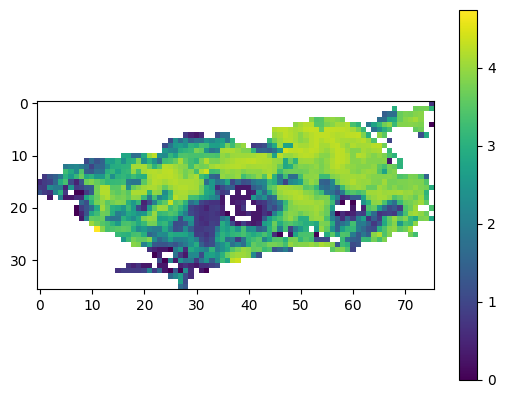

PyObject <matplotlib.colorbar.Colorbar object at 0x7fa98d480240>

In [8]:
file = open("landScan.bin", "r")
data = reinterpret(Int64, read(file))
close(file)

dadosRJ = reshape(data, (36, 76));
dadosRJ[dadosRJ .< 0] .= 0;

PyPlot.imshow(log10.(dadosRJ))
PyPlot.colorbar()

In [9]:
residenciasRJ = ceil.(Int, dadosRJ / 3.3);

In [10]:
d1 = floor.(Int, dadosRJ ./ 10)
d2 = ceil.(Int, d1 / 3.3);

In [11]:
@time populacao = distribuiPessoas(1, d1, d2, 1000, 7000, powerDecay);

  6.286730 seconds (5.49 M allocations: 6.866 GiB, 14.74% gc time)
  5.873591 seconds (84.60 k allocations: 1.186 GiB, 5.06% gc time)
  2.172056 seconds (2.93 M allocations: 414.952 MiB, 1.77% gc time)
244.164814 seconds (35.98 M allocations: 60.308 GiB, 76.80% gc time)


In [14]:
Base.summarysize(populacao) / 1024 / 1024

95.83202362060547

In [16]:
# tem que rever esses parâmetros
α = 1e-1 * ones(populacao.n)
β = 1e-5 * ones(populacao.n)
@time θ = 1e-1 ./ leDistancia(populacao, ones(Bool, populacao.n), ones(Bool, populacao.n), powerDecay);
GC.gc()
γ = 0.2;

 12.217836 seconds (110.55 k allocations: 2.939 GiB, 0.57% gc time)


In [17]:
@time a = evolucaoMista(populacao, Array(1:60), 10, α, β, θ, γ, powerDecay)

  4.450246 seconds (13.26 M allocations: 2.250 GiB, 3.43% gc time)
  2.403216 seconds (7.65 M allocations: 1.993 GiB, 3.32% gc time)
  2.516652 seconds (7.65 M allocations: 1.993 GiB, 3.65% gc time)
  2.462959 seconds (7.65 M allocations: 1.992 GiB, 3.75% gc time)
  2.273987 seconds (7.65 M allocations: 1.993 GiB, 3.54% gc time)
  2.260574 seconds (7.65 M allocations: 1.993 GiB, 3.64% gc time)
  2.401847 seconds (7.65 M allocations: 1.993 GiB, 3.73% gc time)
  2.443610 seconds (7.65 M allocations: 1.992 GiB, 3.64% gc time)
  2.298703 seconds (7.65 M allocations: 1.993 GiB, 3.53% gc time)
  2.314641 seconds (7.65 M allocations: 1.993 GiB, 3.60% gc time)
  2.448656 seconds (7.65 M allocations: 1.993 GiB, 3.65% gc time)
  2.475199 seconds (7.65 M allocations: 1.992 GiB, 3.67% gc time)
  2.296744 seconds (7.65 M allocations: 1.993 GiB, 3.61% gc time)
  2.248605 seconds (7.65 M allocations: 1.993 GiB, 3.70% gc time)
  2.418868 seconds (7.65 M allocations: 1.993 GiB, 3.71% gc time)
  2.48277

([684131.0 684007.0 … 681303.0 680461.0; 684131.0 684020.0 … 681293.0 680439.0; … ; 684131.0 684014.0 … 681315.0 680465.0; 684131.0 684005.0 … 681318.0 680431.0], [1000.0 927.0 … 3099.0 3362.0; 1000.0 929.0 … 3134.0 3401.0; … ; 1000.0 927.0 … 3120.0 3399.0; 1000.0 941.0 … 3105.0 3431.0], [0.0 197.0 … 729.0 1308.0; 0.0 182.0 … 704.0 1291.0; … ; 0.0 190.0 … 696.0 1267.0; 0.0 185.0 … 708.0 1269.0])

In [18]:
(S, I, R) = a;

In [19]:
data = DataFrame(sim = Int[], time = Int[], S = Float64[], I = Float64[], R = Float64[])
for i in 1:5
    append!(data, DataFrame(sim = ones(Int, 5), time = 1:5, S = S[i, :], I = I[i, :], R = R[i, :]))
end

In [20]:
plotData = [Plotly.box(Dict(
    "name" => string(i),
    "x" => data.time,
    "y" => data[:, i],
    "type" => "box"
)) for i in [:S, :I, :R]]

3-element Array{GenericTrace{Dict{Symbol,Any}},1}:
 GenericTrace{Dict{Symbol,Any}}(Dict{Symbol,Any}(:y => [684131.0, 684007.0, 682764.0, 681303.0, 680461.0, 684131.0, 684020.0, 682734.0, 681293.0, 680439.0  …  684131.0, 684025.0, 682907.0, 681416.0, 680592.0, 684131.0, 684003.0, 682996.0, 681448.0, 680589.0],:type => "box",:name => "S",:x => [1, 2, 3, 4, 5, 1, 2, 3, 4, 5  …  1, 2, 3, 4, 5, 1, 2, 3, 4, 5]))
 GenericTrace{Dict{Symbol,Any}}(Dict{Symbol,Any}(:y => [1000.0, 927.0, 1983.0, 3099.0, 3362.0, 1000.0, 929.0, 2044.0, 3134.0, 3401.0  …  1000.0, 924.0, 1888.0, 3015.0, 3291.0, 1000.0, 935.0, 1774.0, 3027.0, 3326.0],:type => "box",:name => "I",:x => [1, 2, 3, 4, 5, 1, 2, 3, 4, 5  …  1, 2, 3, 4, 5, 1, 2, 3, 4, 5]))
 GenericTrace{Dict{Symbol,Any}}(Dict{Symbol,Any}(:y => [0.0, 197.0, 384.0, 729.0, 1308.0, 0.0, 182.0, 353.0, 704.0, 1291.0  …  0.0, 182.0, 336.0, 700.0, 1248.0, 0.0, 193.0, 361.0, 656.0, 1216.0],:type => "box",:name => "R",:x => [1, 2, 3, 4, 5, 1, 2, 3, 4, 5  …  1, 2, 3, 4, 

In [21]:
Plotly.plot(plotData)

data: [
  "box with fields name, type, x, and y",
  "box with fields name, type, x, and y",
  "box with fields name, type, x, and y"
]

layout: "layout with field margin"

# População Aleatória

In [ ]:
# function geraPopulacaoAleatoria(rodada, n, I0, nResidencias, nSociais, bairrosShape, fKernel)
#     """
#         Gera populacao aleatoria de maneira simplificada
#     """
#     nBairros = prod(bairrosShape)
#     pop0 = ones(Int, n)
    
#     # escolhe pessoas aleatorias para comecarem infectadas
#     pop0[StatsBase.sample(1:n, I0, replace=false)] .= 2;

#     # distribui as pessoas nas residencias
#     residencia = rand(1:nResidencias, n)
    
#     # determina que pessoas estão em cada residencia
#     residencias = [Int[] for i in 1:nResidencias]   
#     Threads.@threads for i in 1:nResidencias
#         append!(residencias[i], (1:n)[residencia .== i])
#     end
    
#     # atribui uma posicao e determina o bairro que a residencia pertence
#     residenciasPos = rand(nResidencias, 2) .* bairrosShape'
#     residenciasBai = [
#         ceil(Int, residenciasPos[i, 1]) + 
#         floor(Int, residenciasPos[i, 2]) * bairrosShape[1]
#         for i in 1:nResidencias
#     ]
    
#     # cria listas com residencias
#     residencias = [Residencia(length(j), j, residenciasBai[i], residenciasPos[i, :]) for (i, j) in enumerate(residencias)]
    
#     # cria redes sociais
#     social = rand(1:nSociais, n)
#     sociais = [Social(sum(social .== i), (1:n)[social .== i]) for i in 1:nSociais]
    
#     # determina a posicao e bairro de cada pessoa
#     posicao = zeros(n, 2)
#     bairro = zeros(Int, n)
#     Threads.@threads for i in 1:n
#         posicao[i, :] .= residenciasPos[residencia[i], :]
#         bairro[i] = residenciasBai[residencia[i]]
#     end
    
#     pessoas = Pessoas(residencia, bairro, social, posicao)
    
#     # identifica pessoas e residencias de cada bairro
#     bairrosResidencias = [(1:nResidencias)[residenciasBai .== i] for i in 1:nBairros]
#     bairrosPessoas = [(1:n)[bairro .== i] for i in 1:nBairros]
    
#     # calcula o centro do bairro e a distancia media entre os bairros
#     centros = vcat([mean(posicao[i, :], dims=1) for i in bairrosPessoas]...)
#     dist = hcat([fKernel(centros .- centros[i, :]') for i in 1:nBairros]...)
#     replace!(dist, NaN=>0.)
    
#     #cria lista de bairros e populacao
#     bairros = [
#         Bairro(
#             length(bairrosResidencias[i]),
#             length(bairrosPessoas[i]),
#             bairrosResidencias[i],
#             bairrosPessoas[i],
#             dist[i, :]
#             ) for i in 1:nBairros
#     ]
#     populacao = Populacao(rodada, n, I0, pop0, copy(pop0), pessoas, residencias, bairros, sociais)
    
#     # escreve matriz de distancias das pessoas de cada bairro
#     escreveDistancias(populacao, rodada, fKernel)
#     return populacao
# end

In [ ]:
# function foo(k, bairros)
#     rodada = length(readdir("saidas")) + 1
#     k = floor(Int, k / 100)

#     n = 100 * k
#     I0 = 1 * k
#     nResidencias = 30 * k
#     nSociais = 1 * k
#     return geraPopulacaoAleatoria(rodada, n, I0, nResidencias, nSociais, bairros, powerDecay);
# end

In [ ]:
# bairrosShape = [5, 5]
# @time populacao = foo(1e+5, bairrosShape);

In [ ]:
# data = Dict([
#     "x" => populacao.pessoas.posicao[:, 1],
#     "autobinx" => false,
#     "xbins" => Dict([
#         "start" => 0,
#         "end" => bairrosShape[1],
#         "size" => 1
#     ]),
#     "y"=>populacao.pessoas.posicao[:, 2],
#     "autobiny" => false,
#     "ybins" => Dict([
#         "start" => 0,
#         "end" => bairrosShape[2],
#         "size" => 1
#     ]),
# ]);

# Plotly.plot(Plotly.histogram2d(data))

In [ ]:
# data = Dict([
#     "x"=>populacao.pessoas.posicao[:, 1],
#     "y"=>populacao.pessoas.posicao[:, 2]
# ]);

# Plotly.plot(Plotly.histogram2dcontour(data))

In [ ]:
# # tem que rever esses parâmetros
# α = 1e-1 * ones(populacao.n)
# β = 1e-4 * ones(populacao.n)
# @time θ = 1e-1 ./ leDistancia(populacao, ones(Bool, populacao.n), ones(Bool, populacao.n), powerDecay);
# GC.gc()
# γ = 0.2;

In [ ]:
# @time a = evolucaoMista(populacao, Array(1:5), 10, α, β, θ, γ, powerDecay)

In [ ]:
# (S, I, R) = a;

In [ ]:
# data = DataFrame(sim = Int[], time = Int[], S = Float64[], I = Float64[], R = Float64[])
# for i in 1:5
#     append!(data, DataFrame(sim = ones(Int, 5), time = 1:5, S = S[i, :], I = I[i, :], R = R[i, :]))
# end

In [ ]:
# plotData = [Plotly.box(Dict(
#     "name" => string(i),
#     "x" => data.time,
#     "y" => data[:, i],
#     "type" => "box"
# )) for i in [:S, :I, :R]]

In [ ]:
# Plotly.plot(plotData)